In [1]:
!pip install ray==2.6.1 tensorflow==2.12.1 pyarrow tblib
!pip install --upgrade pandas

In [2]:
import argparse
from filelock import FileLock
import json
import os

import numpy as np
from ray.air.result import Result
import tensorflow as tf

from ray.train.tensorflow import TensorflowTrainer
from ray.air.integrations.keras import ReportCheckpointCallback
from ray.air.config import ScalingConfig


def mnist_dataset(batch_size: int) -> tf.data.Dataset:
    with FileLock(os.path.expanduser("~/.mnist_lock")):
        (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
    # The `x` arrays are in uint8 and have values in the [0, 255] range.
    # You need to convert them to float32 with values in the [0, 1] range.
    x_train = x_train / np.float32(255)
    y_train = y_train.astype(np.int64)
    train_dataset = (
        tf.data.Dataset.from_tensor_slices((x_train, y_train))
        .shuffle(60000)
        .repeat()
        .batch(batch_size)
    )
    return train_dataset


def build_cnn_model() -> tf.keras.Model:
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(28, 28)),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, 3, activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )
    return model


def train_func(config: dict):
    per_worker_batch_size = config.get("batch_size", 64)
    epochs = config.get("epochs", 3)
    steps_per_epoch = config.get("steps_per_epoch", 70)

    tf_config = json.loads(os.environ["TF_CONFIG"])
    num_workers = len(tf_config["cluster"]["worker"])

    strategy = tf.distribute.MultiWorkerMirroredStrategy()

    global_batch_size = per_worker_batch_size * num_workers
    multi_worker_dataset = mnist_dataset(global_batch_size)

    with strategy.scope():
        # Model building/compiling need to be within `strategy.scope()`.
        multi_worker_model = build_cnn_model()
        learning_rate = config.get("lr", 0.001)
        multi_worker_model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
            metrics=["accuracy"],
        )

    history = multi_worker_model.fit(
        multi_worker_dataset,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=[ReportCheckpointCallback()],
    )
    results = history.history
    return results


def train_tensorflow_mnist(
    num_workers: int = 2, use_gpu: bool = False, epochs: int = 4
) -> Result:
    config = {"lr": 1e-3, "batch_size": 64, "epochs": epochs}
    trainer = TensorflowTrainer(
        train_loop_per_worker=train_func,
        train_loop_config=config,
        scaling_config=ScalingConfig(num_workers=num_workers, use_gpu=use_gpu),
    )
    results = trainer.fit()
    return results

2023-09-01 18:48:48,247	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.6.3 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-09-01 18:48:48,828	INFO util.py:159 -- Outdated packages:
  ipywidgets==7.6.3 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-09-01 18:48:49.066230: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 18:48:49.069638: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 18:48:49.145014: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 18:48:49.147583: I 

In [3]:
import ray

In [4]:
runtime_env = {
    'env_vars': {'RAY_AIR_NEW_OUTPUT': '0'}
}

In [5]:
@ray.remote(num_gpus=1, runtime_env=runtime_env)
def f():
    print(ray.get_gpu_ids())

In [6]:
f.remote()

2023-09-01 18:48:53,762	WARNING utils.py:597 -- Ray currently does not support initializing Ray with fractional cpus. Your num_cpus will be truncated from 1.2 to 1.
2023-09-01 18:48:53,824	INFO worker.py:1621 -- Started a local Ray instance.


ObjectRef(c8ef45ccd0112571ffffffffffffffffffffffff0100000001000000)

In [7]:
ray.init(address="ray://example-cluster-head-svc:10001", runtime_env=runtime_env)

Python version:,3.8.13
Ray version:,2.6.1
Dashboard:,http://10.42.1.38:8265


In [8]:
result=train_tensorflow_mnist(num_workers=3, use_gpu=True, epochs=3)

(autoscaler +17s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +17s) Adding 1 node(s) of type large-group.
(autoscaler +27s) Resized to 3 CPUs, 3 GPUs.
(autoscaler +27s) Adding 3 node(s) of type large-group.


(pid=3172) 2023-09-01 11:49:29.382796: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
(pid=3172) To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
(pid=3172) 2023-09-01 11:49:29.590139: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
(pid=3172) 2023-09-01 11:49:30.904648: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib

(RayTrainWorker pid=118, ip=10.42.1.41) Downloading data from https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz
11490434/11490434 [==============================] - 1s 0us/step


(RayTrainWorker pid=649, ip=10.42.2.24) 2023-09-01 11:49:41.822610: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
(RayTrainWorker pid=649, ip=10.42.2.24) op: "TensorSliceDataset"
(RayTrainWorker pid=649, ip=10.42.2.24) input: "Placeholder/_0"
(RayTrainWorker pid=649, ip=10.42.2.24) input: "Placeholder/_1"
(RayTrainWorker pid=649, ip=10.42.2.24) attr {
(RayTrainWorker pid=649, ip=10.42.2.24)   key: "Toutput_types"
(RayTrainWorker pid=649, ip=10.42.2.24)   value {
(RayTrainWorker pid=649, ip=10.42.2.24)     list {
(RayTrainWorker pid=649, ip=10.42.2.24)       type: DT_FLOAT
(RayTrainWorker pid=649, ip=10.42.2.24)       type: DT_INT64
(RayTrainWorker pid=649, ip=10.42.2.24)     }
(RayTrainWorker pid=649, ip=10.42.2.24)   }
(RayTrainWorker pid=649, ip=10.42.2.24) }
(RayTrainWorker 

(RayTrainWorker pid=118, ip=10.42.1.41) Epoch 1/3
(RayTrainWorker pid=649, ip=10.42.2.24) Epoch 1/3
(RayTrainWorker pid=3271) Epoch 1/3


(RayTrainWorker pid=118, ip=10.42.1.41) 2023-09-01 11:49:41.964914: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
(RayTrainWorker pid=3271) 2023-09-01 11:49:41.997602: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
(RayTrainWorker pid=649, ip=10.42.2.24) 2023-09-01 11:49:42.056361: W tensorflow/core/framework/dataset.cc:769] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


70/70 [==============================] - 18s 214ms/step - loss: 2.2676 - accuracy: 0.2165
(RayTrainWorker pid=649, ip=10.42.2.24) Epoch 2/3
(RayTrainWorker pid=3271) Epoch 2/3
(RayTrainWorker pid=118, ip=10.42.1.41) Epoch 2/3
70/70 [==============================] - 15s 216ms/step - loss: 2.2111 - accuracy: 0.3780
(RayTrainWorker pid=3271) Epoch 3/3
70/70 [==============================] - 15s 216ms/step - loss: 2.2111 - accuracy: 0.3780
(RayTrainWorker pid=118, ip=10.42.1.41) Epoch 3/3
70/70 [==============================] - 15s 216ms/step - loss: 2.2111 - accuracy: 0.3780
(RayTrainWorker pid=649, ip=10.42.2.24) Epoch 3/3
70/70 [==============================] - 14s 205ms/step - loss: 2.1424 - accuracy: 0.4932


(TunerInternal pid=2927) Total run time: 83.28 seconds (79.81 seconds for the tuning loop).


In [9]:
from ray.train.tensorflow import TensorflowCheckpoint, TensorflowPredictor

tf_checkpoint: TensorflowCheckpoint = result.checkpoint
predictor = TensorflowPredictor.from_checkpoint(
    tf_checkpoint, model_definition=build_cnn_model
)

In [10]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(len(x_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

print(f"Training Dataset: {len(x_train)} samples")
print(f"Test Dataset: {len(x_test)} samples")

11490434/11490434 [==============================] - 1s 0us/step
Training Dataset: 60000 samples
Test Dataset: 10000 samples


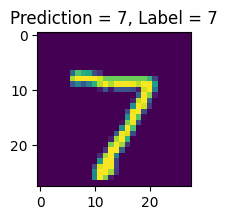

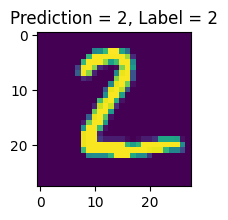

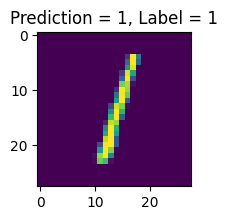

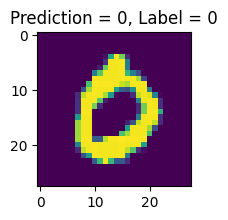

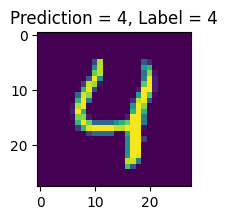

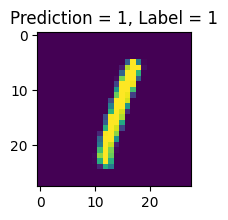

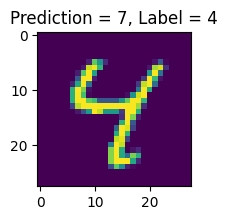

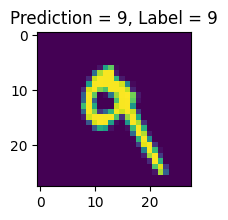

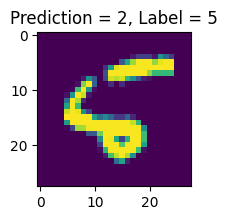

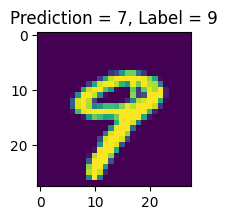

In [12]:
import matplotlib.pyplot as plt

sample_images = x_test[:10]
sample_labels = y_test[:10]
preds = predictor.predict(sample_images)["predictions"].argmax(1)
for image, pred, label in zip(sample_images, preds, sample_labels):
    plt.figure(figsize=(2, 2))
    plt.title(f"Prediction = {pred}, Label = {label}")
    plt.imshow(image.reshape((28, 28)))
    plt.show()